 # Malaria detection

In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plots
import sklearn### machine learning library
from PIL import Image
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import io
import os
import random
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling,Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from tensorflow.keras.callbacks import Callback

C:\Users\junior\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

C:\Users\junior\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Num GPUs Available:  0


In [3]:
dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised = True, shuffle_files = True, split = ["train"])

In [87]:
dataset

[<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [8]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='C:\\Users\\junior\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thi

27558

In [4]:

def splits(dataset,TRAIN_RATIO,VAL_RATIO,TEST_RATIO):
    DATASET_SIZE = len(dataset)
    
    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
    
    val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))
    
    test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset

In [5]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO =0.1

#dataset = tf.data.Dataset.range(10)
train_dataset, val_dataset, test_dataset = splits(dataset[0] , TRAIN_RATIO ,VAL_RATIO,TEST_RATIO)
print(list(val_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)]


# Dataset Visualisation

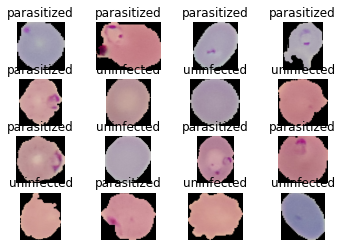

In [5]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image) 
    plt.title(dataset_info.features["label"].int2str(label))
    plt.axis('off')

In [6]:
 dataset_info.features["label"].int2str(0)

'parasitized'

In [43]:
 dataset_info.features["label"].int2str(1)

'uninfected'

# Data Preprocessing

In [6]:
IM_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255.0,label

In [7]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [52]:
for data in train_dataset:
    print(data)
    break

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>, <tf.Tensor: shape=(), dtype=int6

In [8]:
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

# Model Creation

### Sequential

In [9]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    
    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = "relu" ),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
    
    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = "relu" ),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
    
    Flatten(),
    
    Dense(100, activation= 'relu'),
    BatchNormalization(),
    Dense(10, activation= 'relu'),
    BatchNormalization(),
    Dense(1, activation= 'sigmoid')
])
lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                        

In [11]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.1),
             loss = BinaryCrossentropy(from_logits=False),
             metrics = metrics       
            )
             #metrics = RootMeanSquaredError()) 

In [12]:
history = lenet_model.fit(train_dataset, validation_data = val_dataset, epochs= 5, verbose = 1)

Epoch 1/5
689/689 [==============================] - 590s 849ms/step - loss: 0.3972 - accuracy: 0.8291 - fp: 2335.0000 - fn: 1432.0000 - tp: 9595.0000 - tn: 8684.0000 - precision: 0.8043 - recall: 0.8701 - auc: 0.9017 - val_loss: 2.5558 - val_accuracy: 0.4936 - val_fp: 0.0000e+00 - val_fn: 1395.0000 - val_tp: 0.0000e+00 - val_tn: 1360.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4750
Epoch 2/5
689/689 [==============================] - 580s 842ms/step - loss: 0.2768 - accuracy: 0.9086 - fp: 1460.0000 - fn: 556.0000 - tp: 10469.0000 - tn: 9561.0000 - precision: 0.8776 - recall: 0.9496 - auc: 0.9459 - val_loss: 0.3010 - val_accuracy: 0.8929 - val_fp: 281.0000 - val_fn: 14.0000 - val_tp: 1372.0000 - val_tn: 1088.0000 - val_precision: 0.8300 - val_recall: 0.9899 - val_auc: 0.9462
Epoch 3/5
689/689 [==============================] - 580s 842ms/step - loss: 0.2404 - accuracy: 0.9254 - fp: 1229.0000 - fn: 415.0000 - tp: 10607.0000 - tn: 9795.0000 - precision: 0.8962 

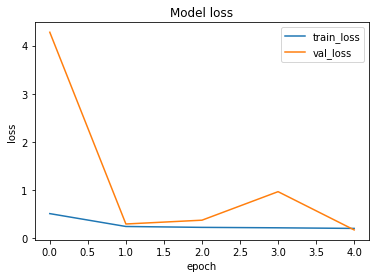

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

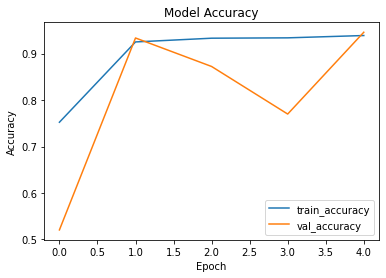

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [32]:
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [30]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [8]:
test_dataset = test_dataset.batch(1)

In [34]:
lenet_model.evaluate(test_dataset)

2757/2757 [==============================] - 46s 16ms/step - loss: 0.3739 - accuracy: 0.8988


[0.373944491147995, 0.8988030552864075]

In [37]:
lenet_model.predict(test_dataset.take(1))

1/1 [==============================] - 3s 3s/step


array([[0.99730015]], dtype=float32)

In [9]:
def parasite_or_not(x):
    if(x<0.5):
        return str('P')
    else:
        return str('U')

In [40]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 3s 3s/step


'U'

1/1 [==============================] - 0s 47ms/step


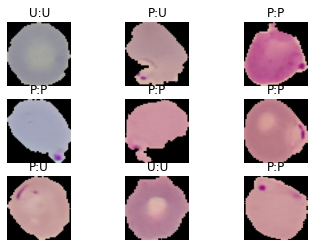

In [42]:
for i, (image,label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[0])
    plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_model.predict(image)[0][0])))
    
    plt.axis('off')

# Functional API

In [47]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input image")

x = Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = "relu" )(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)
    
x = Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = "relu" )(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size = 2, strides = 2)(x)
    

feature_extractor_model = Model(func_input, output, name = 'Feature_Extractor')
feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_20 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_21 (Bat  (None, 109, 109, 16

In [58]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input image")

x = feature_sub_classed(func_input)
    
x = Flatten()(x)
    
x = Dense(100, activation= 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation= 'relu')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation= 'sigmoid')(x)

lenet_model = Model(func_input, func_output, name = 'Lenet Model')
lenet_model.summary()

Model: "Lenet Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor_3 (Featur  (None, 54, 54, 8)        872       
 eExtractor)                                                     
                                                                 
 flatten_8 (Flatten)         (None, 23328)             0         
                                                                 
 dense_24 (Dense)            (None, 100)               2332900   
                                                                 
 batch_normalization_32 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_25 (Dense)            (None, 10)                

# Model Subclassing

In [14]:
class LenetModel(Model):
    def __init__(self):
        super(LenetModel, self).__init__()
        
        self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu",2)
        
        self.flatten = Flatten()
    
        self.dense_1 = Dense(100, activation= 'relu')
        self.batch_1= BatchNormalization()

        self.dense_2 = Dense(10, activation= 'relu')
        self.batch_2= BatchNormalization()


        self.dense_3 = Dense(1, activation= 'sigmoid')
        
    def call(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x)
        
        x = self.dense_2(x)
        x = self.batch_2(x)
        x = self.dense_3(x)
        
        return x
lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1,224,224,3]))
lenet_sub_classed.summary()

Model: "lenet_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_3 (Featur  multiple                 872       
 eExtractor)                                                     
                                                                 
 flatten_2 (Flatten)         multiple                  0         
                                                                 
 dense_3 (Dense)             multiple                  2332900   
                                                                 
 batch_normalization_10 (Bat  multiple                 400       
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             multiple                  1010      
                                                                 
 batch_normalization_11 (Bat  multiple               

In [16]:
class FeatureExtractor(Layer):
    def __init__(self,filters, kernel_size, strides, padding, activation,pool_size):
        super(FeatureExtractor, self).__init__()
        
        self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
        self.batch_1 = BatchNormalization()
        self.pool_1 =  MaxPool2D(pool_size = pool_size, strides = 2*strides)
        
        self.conv_2 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation )
        self.batch_2 = BatchNormalization()
        self.pool_2 =  MaxPool2D(pool_size = pool_size, strides = 2*strides)
    
    def call(self, x):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.pool_1(x)
        
        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)
        return x
feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu",2)


## Custom Layers

In [25]:
class NeuralearnDense(Layer):
    def __init__(self, output_units, activation):
        super(NeuralearnDense, self).__init__()
        self.output_units = output_units
        self.activation = activation
        
    def build(self, input_features_shape ):
        self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units),initializer = "random_normal", trainable = True)
        self.b = self.add_weight(shape = (self.output_units),initializer = "random_normal", trainable = True)
    
    def call(self, input_features):
        if(self.activation == 'relu'):
            return tf.nn.relu(tf.matmul( input_features, self.w) + self.b)
        
        elif(self.activation == "sigmoid"):
            return tf.math.sigmoid(tf.matmul( input_features, self.w) + self.b)
            
        else:
            return tf.matmul( input_features, self.w) + self.b
            
            

In [ ]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    
    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = "relu" ),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
    
    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = "relu" ),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
    
    Flatten(),
    
    Dense(100, activation= 'relu'),
    BatchNormalization(),
    Dense(10, activation= 'relu'),
    BatchNormalization(),
    Dense(1, activation= 'sigmoid')
])
lenet_model.summary()

### Precision , Recall and Accuracy

In [10]:
metrics = [BinaryAccuracy(name = 'accuracy'), FalsePositives(name = "fp"), FalseNegatives(name = 'fn'), TruePositives(name = 'tp'), TrueNegatives(name = 'tn'), Precision(name = 'precision'), Recall(name = 'recall'), AUC(name = 'auc')]

# Visualizing Confusion Matrix

In [15]:
labels = []
inp = []
for x,y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

In [20]:
labels = np.array([i for i in labels])
labels

array([0, 1, 0, ..., 1, 0, 1], dtype=int64)

In [23]:
print(np.array(inp).shape)


(2757, 224, 224, 3)


In [26]:
predicted = lenet_model.predict(np.array(inp))
print(predicted)

87/87 [==============================] - 14s 159ms/step
[[2.0286635e-02]
 [9.5121217e-01]
 [2.4350830e-04]
 ...
 [9.5316124e-01]
 [4.4525605e-02]
 [7.1574020e-01]]


In [27]:
predicted.shape

(2757, 1)

### Confusion Matrix

[[1322   68]
 [ 124 1243]]


Text(0.5, 51.0, 'Predicted')

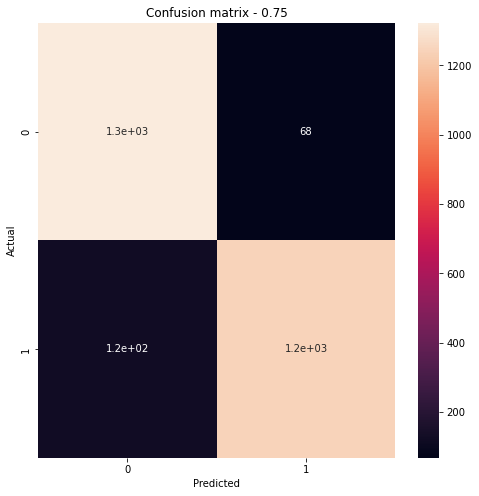

In [35]:
threshold = 0.75

cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.figure(figsize = (8,8))

sns.heatmap(cm, annot = True)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel("Actual")
plt.xlabel('Predicted')

### ROC Plots

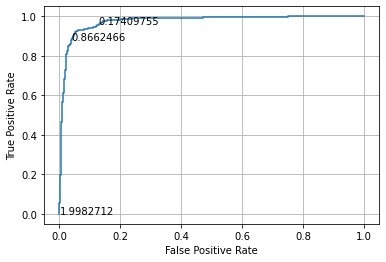

In [39]:
fp,tp, thresholds = roc_curve(labels, predicted)
plt.plot(fp,tp)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.grid()

skip = 20

for i in range(0, len(thresholds), skip):
    plt.text(fp[i], tp[i], thresholds[i])
plt.show()

### Callbacks

In [ ]:
class LossCallback(Callback):
    def on_epoch_end(epoch):
        print("For Epoch Number {} the model has a loss of {}".format(epoch, logs["loss"]))